In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import match_coordinates_sky
from tqdm.notebook import tqdm

import healpy as hp

In [2]:
waves_s_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_s_ultralite.parquet'
waves_n_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_n_ultralite.parquet'

In [3]:
cat = pq.read_table(waves_s_filepath).to_pandas()
#cat.loc[cat['starmask'] == 1, 'class'] = 'star'
cat = cat[(cat['duplicate']==0)]

In [6]:
len(cat)

51472028

In [127]:
stars_path = '/Users/sp624AA/Downloads/Masking/gaiastarmaskwaves.csv'

In [128]:
stars = pd.read_csv(stars_path)

In [130]:
stars = stars[(stars['dec'] < -10) & (stars['phot_g_mean_mag'] <= 16)]

In [131]:
def mask_radius_waves(g):
    """
    Calculate r[arcmin] based on the given formula.

    Parameters:
        g (float or array-like): Input magnitude.

    Returns:
        numpy.ndarray: Calculated r[arcmin].
    """
    g = np.asarray(g)  # Ensure g is a NumPy array
    r = np.zeros_like(g, dtype=float)
    mask1 = (g > 3.5) & (g < 16)
    mask2 = g <= 3.5
    r[mask1] = (10 ** (1.3 - 0.13 * g[mask1])) 
    r[mask2] = 7 
    return r

In [132]:
stars['mask_radius'] = mask_radius_waves(stars['phot_g_mean_mag'])

In [133]:
sel = (stars['phot_g_mean_mag'] > 8) & (stars['phot_g_mean_mag'] < 13)

#stars = stars[stars['phot_g_mean_mag'] <= 8]
stars = stars[sel]

In [134]:
min(stars['phot_g_mean_mag'])

8.00186157

In [136]:

# Input arrays
stars_coords = SkyCoord(ra=np.array(stars['ra'])*u.deg, dec=np.array(stars['dec'])*u.deg)
sources_coords = SkyCoord(ra=np.array(cat['RAmax'])*u.deg, dec=np.array(cat['Decmax'])*u.deg)


In [137]:
nside = 1024*16
npix = hp.nside2npix(nside)

# Assign HEALPix pixels to all sources
ipix_sources = hp.ang2pix(nside, 0.5*np.pi - sources_coords.dec.rad, sources_coords.ra.rad)

density_map = np.bincount(ipix_sources, minlength=npix).astype(np.float32)

radii = np.array(stars['mask_radius'])  # in arcmin

# Prepare stacked histogram
nbins = 50
extent = 3

query_extent = 5

stacked = np.zeros((nbins, nbins))
xedges = np.linspace(-extent, extent, nbins + 1)
yedges = np.linspace(-extent, extent, nbins + 1)

rad_to_arcmin = 180/np.pi * 60  # ≈3437.75

for i in tqdm(range(len(stars))):
    ra0 = stars_coords.ra.rad[i]
    dec0 = stars_coords.dec.rad[i]
    R_arcmin = radii[i]
    R_deg = R_arcmin * query_extent / 60.0  # 3×R in degrees

    vec = hp.ang2vec(0.5 * np.pi - dec0, ra0)
    ipix_disc = hp.query_disc(nside, vec, np.radians(R_deg), inclusive=True)
    
    # DEBUG: print number of pixels found per star
    # print(f'Star {i}: pixels in disc = {len(ipix_disc)}')

    for ipix in ipix_disc:
        theta, phi = hp.pix2ang(nside, ipix)
        ra_pix = phi
        dec_pix = 0.5 * np.pi - theta

        dra = (ra_pix - ra0) * np.cos(dec0)
        ddec = dec_pix - dec0

        x = (dra * rad_to_arcmin) / R_arcmin
        y = (ddec * rad_to_arcmin) / R_arcmin

        if abs(x) < extent and abs(y) < extent:
            ix = np.searchsorted(xedges, x) - 1
            iy = np.searchsorted(yedges, y) - 1
            if 0 <= ix < nbins and 0 <= iy < nbins:
                stacked[iy, ix] += density_map[ipix]


  0%|          | 0/50592 [00:00<?, ?it/s]

In [141]:
stacked[1]

array([5095., 5187., 5093., 5120., 5284., 5189., 5240., 5307., 5175.,
       5276., 5117., 5388., 5320., 5152., 5290., 5439., 5322., 5225.,
       5396., 5606., 5345., 5256., 5389., 5306., 5411., 5580., 5016.,
       5429., 5297., 5577., 5450., 5369., 5206., 5564., 5275., 5181.,
       5333., 5168., 5067., 5134., 5343., 5240., 5142., 5189., 5288.,
       5072., 5237., 5214., 5138., 5200.])

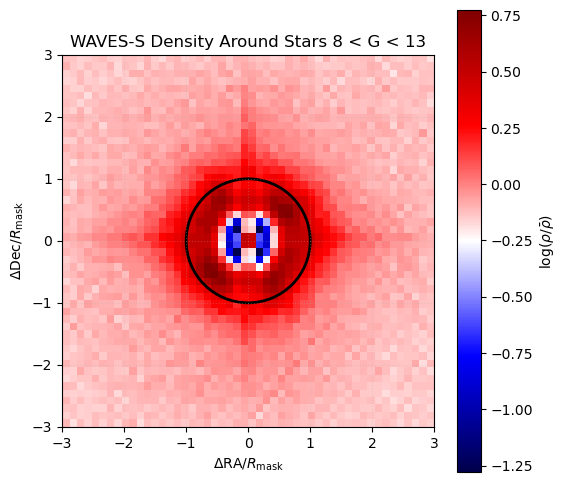

In [142]:
#import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Convert edges to bin centers for plotting (optional)
Xc = 0.5 * (xedges[:-1] + xedges[1:])
Yc = 0.5 * (yedges[:-1] + yedges[1:])
XX, YY = np.meshgrid(Xc, Yc)

pcm = ax.pcolormesh(
    xedges, yedges, np.log(stacked/np.mean(stacked)),  # log1p = log(1 + x) for nicer color scale
    cmap='seismic',
    shading='auto'
)

ax.set_xlabel(r'$\Delta \mathrm{RA} / R_{\mathrm{mask}}$')
ax.set_ylabel(r'$\Delta \mathrm{Dec} / R_{\mathrm{mask}}$')
ax.set_title('WAVES-S Density Around Stars 8 < G < 13')
ax.set_xlim(-extent, extent)
ax.set_ylim(-extent, extent)
ax.set_aspect('equal')
# Create a circle with radius 1 centered at (x, y) = (2, 2)
circle = patches.Circle((0, 0), 1, fill=False, color='black', linewidth=2)

# Add the circle to the axis
ax.add_patch(circle)
# Colorbar
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label(r'$\log(\rho/\bar{\rho})$')

plt.grid(alpha=0.3, linestyle=':')
plt.savefig('waves-s-all-8<g<13')
plt.show()

